In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import os
import sys
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# torch.cuda.is_available()

import gym

In [2]:
seed = 12

os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

random.seed(seed)
np.random.seed(seed)

# env.seed(seed)  这个等创建了环境之后再设置

torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [3]:
os.chdir(os.path.dirname(os.path.abspath(__file__)))
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.append(path)

In [4]:
from configs import Config
from replay_memories import ExperienceReplayMemory
from networks_pytorch import MLP_pytorch
from agents_pytorch import DQNAgentPytorch

# Training Loop

## CartPole-v0

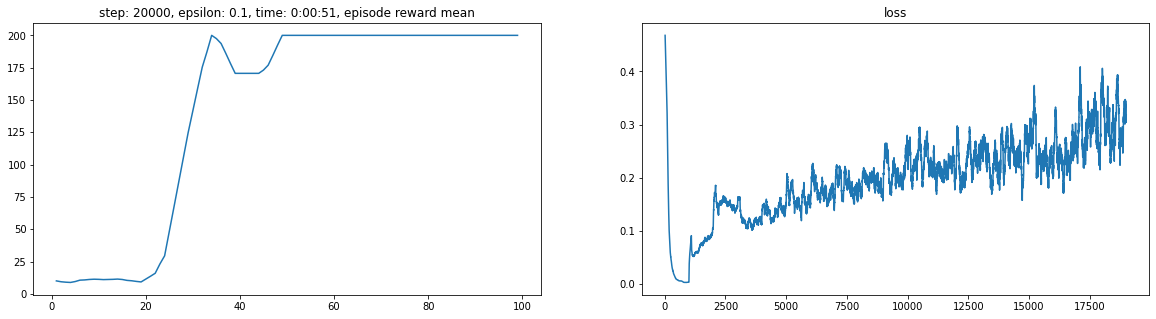

step: 21000, epsilon: 0.1, lr: 0.0001, time: 0:00:54
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.22624981701374053
step: 22000, epsilon: 0.1, lr: 0.0001, time: 0:00:56
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.486078847758472
step: 23000, epsilon: 0.1, lr: 0.0001, time: 0:00:59
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.25218032784759997
step: 24000, epsilon: 0.1, lr: 0.0001, time: 0:01:01
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.14314236370846628
step: 25000, epsilon: 0.1, lr: 0.0001, time: 0:01:04
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.4160052839666605
a new render begins
step: 25000, epsilon: 0.1, time: 0:01:04
ep

In [6]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgentPytorch(env_name=name, network=MLP_pytorch, double=True, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.param_groups[0]['lr'], timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

In [7]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

199.91


In [8]:
dqn_agent.render(env_eval)

## LunarLander-v2

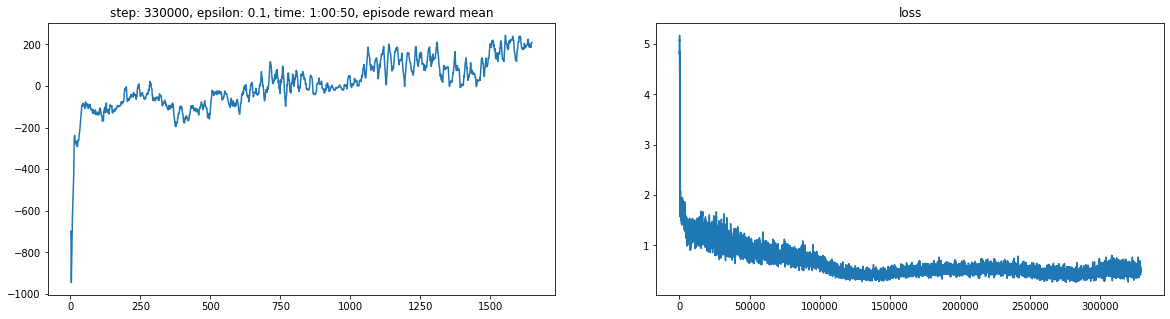

step: 331000, epsilon: 0.1, lr: 0.0001, time: 1:00:58
episode reward mean: 172.73852128053173, epsisode reward max: 255.72218401506194, episode length mean: 589.6, episode length max: 1000, loss: 0.2917916551232338
step: 332000, epsilon: 0.1, lr: 0.0001, time: 1:01:05
episode reward mean: 233.61395955901133, epsisode reward max: 275.4041809707602, episode length mean: 441.6, episode length max: 593, loss: 0.4812767691910267
step: 333000, epsilon: 0.1, lr: 0.0001, time: 1:01:13
episode reward mean: 245.6841470877057, epsisode reward max: 313.78316759479276, episode length mean: 447.2, episode length max: 703, loss: 0.6942166097462177
a new render begins
step: 333000, epsilon: 0.1, time: 1:01:16
episode reward mean: 238.37612707799607, epsisode reward max: 270.5652556397335, episode length mean: 419.0, episode length max: 634


In [6]:
name = 'LunarLander-v2'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()


start = timer()

dqn_agent = DQNAgentPytorch(env_name=name, network=MLP_pytorch, double=True, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.param_groups[0]['lr'], timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > 200:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

In [7]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

231.63371545045015


In [9]:
dqn_agent.render(env_eval)

In [8]:
torch.save(dqn_agent.model.state_dict(), 'doubledqn_lunarlander.pt')